# Milestone 2

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import os
import bz2
from src.QuoteBankData import QuoteBankData
from src.Deaths import Deaths
import src.utilities.quotebank_preprocessing_utils as utils
from src.CONSTS import DATA_PATH, COLORS
from tqdm import tqdm

# Quotebank preprocessing

Most of the code used for the quotebank preprocessing can be found in the classes QuotebankData and Keyword, in addition to in files for helper functions. 

In [ ]:
def quotation_classification():
    """
    Iterate through all quotebank files, stored locally. For each quote inside the file, check which keywords match.
    Store the results in the respective output
    """
    quotes_filenames_list = utils.compose_quotebank_filenames()

    for index, filename in enumerate(quotes_filenames_list):
        print("Elaborating file: " + filename.split("/").pop())
        quotation_classification_for_file(filename)
        quotebank.write_matching_quotes_to_file_for_year(index)
        quotebank.delete_json_lines_for_all_keywords()

In [ ]:
def quotation_classification_for_file(filename):
    """
    For every line of the input file (json file), extract the quotation.
    If any of the keyword is found inside the quotation, the corresponding (json) line gets saved inside json_lines attribute of the corresponding
    keyword object.
    :param filename: str 
    """
    if not os.path.isfile(filename):
        print(filename + " doesn't exist")
        return

    with bz2.open(filename, "rb") as file:
        for i, line in tqdm(enumerate(file)):
            if i == 100000: break
            quotation = utils.extract_quotation(line)
            found_keywords = quotebank.match_quotation_with_any_keyword(quotation)
            if len(found_keywords) > 0:
                for found_keyword in found_keywords:
                    found_keyword.json_lines.append(line)

Initialize quotebank
- read keyword and synonyms for death causes
- create folders and file names for quotes that matches keywords or synonyms
- match keywords and synonyms with quotes

In [ ]:
quotebank = QuoteBankData("Asymmetry of News", [])
quotebank.read_keywords_from_file()
utils.create_directories_for_every_year()
quotebank.create_json_dumps_filenames_for_each_keyword()
quotation_classification()

To illustrate the results, we plot the number of quotes found for each issue in 2016

In [ ]:
occurences = list()
x_labels=list()
x_number = list()
count = 0
for keys in quotebank.keywords:
    with open(keys.output_filenames[8], 'rU') as f:
        keys.quotes = pd.read_json(keys.output_filenames[8], lines=True)
    occurences.append(len(keys.quotes))
    x_labels.append(keys.name)
    x_number.append(count)
    count += 1

In [ ]:
plt.bar(x_number, occurences, log = True)
plt.xticks(x_number, x_labels)
plt.xticks(rotation=90)
plt.title("Number of occurences per topic in 2016")
plt.xlabel("Topics")
plt.ylabel("Number of occurences")
plt.show()

In [ ]:
def freq_per_month(df):
    freqs = np.zeros(12)
    for i in range(12):
        freqs[i] = np.sum(df["date"].dt.month == i+1)
    return freqs

In [ ]:
all_freq = list()
for keys in quotebank.keywords:
    if not keys.quotes.empty:
        all_freq.append(freq_per_month(keys.quotes))
    else:
        all_freq.append(np.zeros(12))
df = pd.DataFrame(all_freq)

plt.plot(np.sum(df))
plt.title("Number of topic quotes found throughout the year 2016")
plt.show()

# Population data preprocessing
This is population data from the UN, which we might use in combination with the Our World in Data datasets to get a more realistic understanding of the relative deaths each year.

In [ ]:
population_path = DATA_PATH + "annual_population_data.csv"
raw_population_df = pd.read_csv(population_path)
raw_population_df

Extracting world population in millions from 2008 to 2017

In [ ]:
population_df = raw_population_df[(raw_population_df["Location"] == "World") & (raw_population_df["Time"] > 2007) & (raw_population_df["Time"] < 2018)]
population_df = population_df[["Time", "PopTotal"]].reset_index(drop=True)
population_df["PopTotal"] = population_df["PopTotal"].apply(lambda x: x/1000)
population_df = population_df.rename(columns = {"Time": "Year", "PopTotal": "World population millions"})
population_df

# Our World in Data preprocessing

This part of the notebook is more exploratory. We wanted to preprocess and look at the two main datasets form Our World in Data to be sure that the project is possible to do. 

## Fetch and preprocess death data

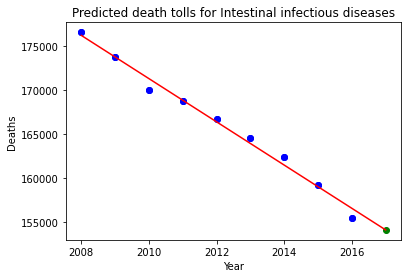

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Protein-energy malnutrition,Terrorism,Cardiovascular diseases,Alzheimer disease and other dementias,...,Neonatal disorders,Alcohol use disorders,Exposure to forces of nature,Diarrheal diseases,Environmental heat and cold exposure,Nutritional deficiencies,Self-harm,Conflict and terrorism,Diabetes mellitus,Poisonings
0,World,OWID_WRL,2008,348040.083847,2.657275e+06,176583.045171,304321.884855,9157.0,1.500828e+07,1.790400e+06,...,2.304429e+06,179987.013172,235496.829431,1.867836e+06,60384.613529,345703.367968,789447.007136,58795.082371,1.045381e+06,78008.099106
1,World,OWID_WRL,2009,340514.177436,2.639562e+06,173745.686452,297263.561629,9273.0,1.527431e+07,1.863444e+06,...,2.258315e+06,175052.864372,9254.003678,1.865671e+06,59023.804629,338690.981517,791222.757559,67916.308722,1.070186e+06,77339.491051
2,World,OWID_WRL,2010,331205.914662,2.623649e+06,170071.404053,299956.052686,7827.0,1.561962e+07,1.943961e+06,...,2.211208e+06,174237.378348,248454.699157,1.857640e+06,115382.599926,341835.027741,796083.645174,50608.273695,1.096402e+06,77298.902918
3,World,OWID_WRL,2011,325000.383494,2.616651e+06,168716.792532,288907.141759,8246.0,1.585974e+07,2.025064e+06,...,2.162070e+06,170736.669200,31964.196615,1.793641e+06,57402.483668,329818.068512,793977.906088,100568.611560,1.129959e+06,76227.682073
4,World,OWID_WRL,2012,316965.020009,2.605154e+06,166735.397312,269574.084338,15497.0,1.611549e+07,2.098871e+06,...,2.110626e+06,169930.031855,6625.594444,1.725018e+06,57658.367887,309650.953725,786335.554940,111432.890101,1.168569e+06,75414.520357
5,World,OWID_WRL,2013,312013.523643,2.590482e+06,164572.376351,259203.023575,22273.0,1.628402e+07,2.168918e+06,...,2.050610e+06,170965.247716,19050.473289,1.664193e+06,55823.991356,298365.543019,779212.549795,115138.255671,1.202743e+06,74906.641101
6,World,OWID_WRL,2014,306484.322622,2.579538e+06,162420.462719,250311.830788,44490.0,1.662836e+07,2.253866e+06,...,1.989193e+06,173684.698467,6503.060539,1.619718e+06,55072.834100,289184.845108,781716.697241,182239.944451,1.249135e+06,74439.682294
7,World,OWID_WRL,2015,298711.517721,2.582199e+06,159257.591692,243750.598948,38853.0,1.713999e+07,2.353634e+06,...,1.925458e+06,178372.485978,14748.187609,1.578439e+06,57740.167042,282498.011863,782941.162890,137629.287532,1.299556e+06,74394.517062
8,World,OWID_WRL,2016,295878.990018,2.574625e+06,155448.606112,236429.610442,34871.0,1.752437e+07,2.440042e+06,...,1.852924e+06,181679.094522,7261.252562,1.550848e+06,54183.052891,274881.027448,788674.564776,158356.402289,1.346428e+06,73643.079320
9,World,OWID_WRL,2017,288021.105387,2.558606e+06,154107.234208,231770.992044,26445.0,1.779095e+07,2.514619e+06,...,1.783770e+06,184934.241760,9602.935057,1.569556e+06,53349.518780,269996.917689,793823.469135,129720.145674,1.369849e+06,72370.531920


In [2]:
death_by_cause_path = DATA_PATH + "annual_number_of_deaths_by_cause.csv"
deaths_by_cause = Deaths("deaths_by_cause", death_by_cause_path, rename_cols = {'Terrorism (deaths)': 'Terrorism'}, drop_cols = ['Number of executions (Amnesty International)'])
deaths_by_cause.df

In [3]:
deaths_by_cause.percentage_df

,Entity,Code,Year,Meningitis,Lower respiratory infections,Intestinal infectious diseases,Protein-energy malnutrition,Terrorism,Cardiovascular diseases,Alzheimer disease and other dementias,...,Neonatal disorders,Alcohol use disorders,Exposure to forces of nature,Diarrheal diseases,Environmental heat and cold exposure,Nutritional deficiencies,Self-harm,Conflict and terrorism,Diabetes mellitus,Poisonings
0,World,OWID_WRL,2008,0.700192,5.345947,0.355253,0.612240,0.018422,30.193900,3.601955,...,4.636086,0.362101,0.473776,3.757741,0.121483,0.695491,1.588222,0.118285,2.103115,0.156938
1,World,OWID_WRL,2009,0.682428,5.289976,0.348206,0.595749,0.018584,30.611429,3.734549,...,4.525914,0.350825,0.018546,3.739013,0.118290,0.678774,1.585699,0.136112,2.144772,0.154997
2,World,OWID_WRL,2010,0.653592,5.177430,0.335614,0.591924,0.015446,30.823280,3.836153,...,4.363531,0.343835,0.490293,3.665810,0.227693,0.674567,1.570967,0.099869,2.163606,0.152539
3,World,OWID_WRL,2011,0.640791,5.159152,0.332653,0.569627,0.016258,31.270041,3.992743,...,4.262872,0.336635,0.063023,3.536454,0.113178,0.650290,1.565456,0.198287,2.227897,0.150295
4,World,OWID_WRL,2012,0.622269,5.114465,0.327337,0.529231,0.030424,31.638096,4.120525,...,4.143603,0.333608,0.013007,3.386573,0.113196,0.607910,1.543742,0.218766,2.294146,0.148055
5,World,OWID_WRL,2013,0.610462,5.068342,0.321990,0.507137,0.043578,31.860088,4.243542,...,4.012069,0.334498,0.037273,3.256034,0.109221,0.583759,1.524548,0.225271,2.353196,0.146557
6,World,OWID_WRL,2014,0.591830,4.981157,0.313638,0.483359,0.085911,32.109811,4.352276,...,3.841186,0.335390,0.012558,3.127720,0.106347,0.558424,1.509516,0.351910,2.412113,0.143745
7,World,OWID_WRL,2015,0.567101,4.902279,0.302349,0.462758,0.073762,32.540099,4.468350,...,3.655462,0.338638,0.027999,2.996650,0.109619,0.536320,1.486406,0.261288,2.467194,0.141237
8,World,OWID_WRL,2016,0.554221,4.822619,0.291176,0.442864,0.065318,32.825503,4.570527,...,3.470776,0.340309,0.013601,2.904948,0.101492,0.514889,1.477294,0.296623,2.522040,0.137943
9,World,OWID_WRL,2017,0.534836,4.751165,0.286167,0.430384,0.049107,33.036636,4.669484,...,3.312345,0.343411,0.017832,2.914563,0.099067,0.501367,1.474079,0.240882,2.543720,0.134387


In [4]:
death_by_category_path = DATA_PATH + "categorized_annual_number_of_deaths.csv"
deaths_by_category = Deaths("deaths_by_category", death_by_category_path)
deaths_by_category.df

,Entity,Code,Year,Non-communicable diseases,"Communicable, maternal, neonatal, and nutritional diseases",Injuries
0,World,OWID_WRL,2008,3.418150e+07,1.308734e+07,4.634715e+06
1,World,OWID_WRL,2009,3.483548e+07,1.281121e+07,4.425399e+06
2,World,OWID_WRL,2010,3.559222e+07,1.252802e+07,4.718076e+06
3,World,OWID_WRL,2011,3.621622e+07,1.219007e+07,4.487698e+06
4,World,OWID_WRL,2012,3.683037e+07,1.180971e+07,4.462361e+06
5,World,OWID_WRL,2013,3.735997e+07,1.146154e+07,4.452354e+06
6,World,OWID_WRL,2014,3.825766e+07,1.117078e+07,4.507679e+06
7,World,OWID_WRL,2015,3.945300e+07,1.088245e+07,4.486745e+06
8,World,OWID_WRL,2016,4.040355e+07,1.060071e+07,4.505297e+06
9,World,OWID_WRL,2017,4.107113e+07,1.038987e+07,4.484722e+06


In [5]:
deaths_by_category.percentage_df

,Entity,Code,Year,Non-communicable diseases,"Communicable, maternal, neonatal, and nutritional diseases",Injuries
0,World,OWID_WRL,2008,65.855794,25.214733,8.929473
1,World,OWID_WRL,2009,66.898568,24.602832,8.498600
2,World,OWID_WRL,2010,67.360623,23.710107,8.929270
3,World,OWID_WRL,2011,68.469444,23.046231,8.484325
4,World,OWID_WRL,2012,69.357208,22.239485,8.403306
5,World,OWID_WRL,2013,70.128132,21.514385,8.357483
6,World,OWID_WRL,2014,70.931427,20.711133,8.357440
7,World,OWID_WRL,2015,71.965378,19.850444,8.184177
8,World,OWID_WRL,2016,72.786653,19.097091,8.116256
9,World,OWID_WRL,2017,73.412455,18.571344,8.016201


## Plotting

### Deaths by cause

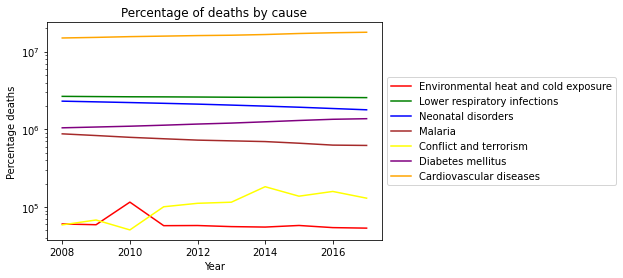

In [6]:
deaths_by_cause.plot_lines("Percentage deaths", "Percentage of deaths by cause")

### Deaths by category

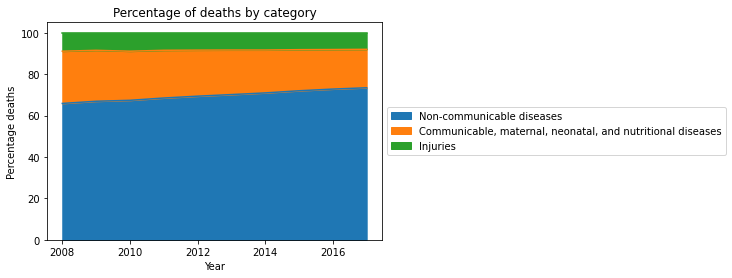

In [7]:
deaths_by_category.plot_stacked_areas("Percentage deaths", "Percentage of deaths by category")